In [1]:
# !pip install 'zarr<3'
# !pip install timm


In [2]:

# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


In [3]:
import os
import glob
import numpy as np
import zarr
import pandas as pd
import cv2
import scipy.io
from pathlib import Path
from tqdm import tqdm
import numcodecs

# --- CONFIGURATION ---
BASE_PATH = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/kumar")
OUTPUT_BASE = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/kumar/zarr_data")

# Patching Configuration
PATCH_SIZE = 512
STRIDE = 450  # 450 stride = ~60px overlap. Ensures we cover 1000x1000 images well.

cv2.setNumThreads(0)

# ---------------------------------------------------------------------
# 1. Helper: Read MATLAB Masks
# ---------------------------------------------------------------------
def read_mat_mask(mat_path):
    """
    Load instance mask from .mat file.
    The Kumar dataset .mat files usually contain the mask in 'inst_map' or similar keys.
    """
    try:
        mat = scipy.io.loadmat(str(mat_path))
        
        # Common keys used in nuclei segmentation datasets
        possible_keys = ['inst_map', 'instance_map', 'map', 'mask']
        
        mask = None
        for key in possible_keys:
            if key in mat:
                mask = mat[key]
                break
        
        # Fallback: find the first array that matches expected dimensions (2D)
        if mask is None:
            for key, val in mat.items():
                if isinstance(val, np.ndarray) and val.ndim == 2 and key not in ['__header__', '__version__', '__globals__']:
                    mask = val
                    break

        if mask is None:
            raise ValueError(f"Could not find mask array in {mat_path.name}. Keys: {mat.keys()}")

        return mask.astype(np.int32)
        
    except Exception as e:
        print(f"❌ Error reading .mat {mat_path.name}: {e}")
        return None

# ---------------------------------------------------------------------
# 2. Helper: Tile Generator
# ---------------------------------------------------------------------
def extract_tiles(image, mask, patch_size=512, stride=450):
    """
    Extracts patches from image and mask. 
    Uses a 'shift-back' strategy for edges to ensure full image coverage 
    without padding (if image size > patch size).
    """
    h, w = image.shape[:2]
    tiles = []
    
    # Generate coordinates
    y_steps = list(range(0, h - patch_size + 1, stride))
    if (h - patch_size) % stride != 0:
        y_steps.append(h - patch_size) # Add last valid crop
        
    x_steps = list(range(0, w - patch_size + 1, stride))
    if (w - patch_size) % stride != 0:
        x_steps.append(w - patch_size) # Add last valid crop

    # Unique steps to avoid duplicates if stride aligns perfectly
    y_steps = sorted(list(set(y_steps)))
    x_steps = sorted(list(set(x_steps)))

    for y in y_steps:
        for x in x_steps:
            img_patch = image[y:y+patch_size, x:x+patch_size, :]
            mask_patch = mask[y:y+patch_size, x:x+patch_size]
            
            tiles.append({
                'image': img_patch,
                'mask': mask_patch,
                'y': y,
                'x': x
            })
            
    return tiles

# ---------------------------------------------------------------------
# 3. Process Single Split (Train/Val/Test)
# ---------------------------------------------------------------------
def process_split_folder(split_name, folder_name):
    """
    Process a specific folder (e.g., 'train') and save to zarr under 'kumar_train'.
    """
    img_dir = BASE_PATH / folder_name / "Images"
    lbl_dir = BASE_PATH / folder_name / "Labels"
    
    if not img_dir.exists() or not lbl_dir.exists():
        print(f"⚠️  Skipping {split_name}: directories not found.")
        return 0, 0

    print(f"\n📂 Processing {split_name} (Source: {folder_name})...")
    
    img_files = sorted(list(img_dir.glob("*.tif")))
    
    all_patches_img = []
    all_patches_mask = []
    all_metadata = []
    
    for img_path in tqdm(img_files, desc=f"  Extracting {split_name}"):
        # Match mask file (same basename, but .mat)
        mask_path = lbl_dir / (img_path.stem + ".mat")
        
        if not mask_path.exists():
            print(f"  ⚠️ Mask missing for {img_path.name}")
            continue
            
        # 1. Load Data
        img = cv2.imread(str(img_path))
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = read_mat_mask(mask_path)
        if mask is None: continue
        
        # 2. Extract Tiles
        patches = extract_tiles(img, mask, PATCH_SIZE, STRIDE)
        
        # 3. Collect
        for p in patches:
            all_patches_img.append(p['image'])
            all_patches_mask.append(p['mask'])
            
            all_metadata.append({
                'original_file': img_path.name,
                'patch_y': p['y'],
                'patch_x': p['x'],
                'original_height': img.shape[0],
                'original_width': img.shape[1]
            })

    if not all_patches_img:
        print(f"⚠️  No valid patches created for {split_name}")
        return 0, 0

    # Stack
    final_images = np.stack(all_patches_img, axis=0)
    final_masks = np.stack(all_patches_mask, axis=0)
    
    # 4. Save to Zarr
    save_dir = OUTPUT_BASE / split_name
    os.makedirs(save_dir, exist_ok=True)
    
    compressor = numcodecs.Blosc(cname='zstd', clevel=3)
    
    # Save Images
    z_img = zarr.open_array(
        str(save_dir / 'images.zarr'),
        mode='w',
        shape=final_images.shape,
        chunks=(1, PATCH_SIZE, PATCH_SIZE, 3),
        dtype='uint8',
        compressor=compressor
    )
    z_img[:] = final_images
    
    # Save Masks
    z_mask = zarr.open_array(
        str(save_dir / 'nuclei_masks.zarr'),
        mode='w',
        shape=final_masks.shape,
        chunks=(1, PATCH_SIZE, PATCH_SIZE),
        dtype='int32',
        compressor=compressor
    )
    z_mask[:] = final_masks
    
    # Save Metadata
    pd.DataFrame(all_metadata).to_csv(save_dir / 'metadata.csv', index=False)
    
    # Stats
    unique_inst = len(np.unique(final_masks)) - 1 # subtract background
    print(f"   ✅ Saved {len(final_images)} tiles to {split_name}")
    
    return len(final_images), unique_inst

# ---------------------------------------------------------------------
# 4. Main Pipeline
# ---------------------------------------------------------------------
def main():
    print("="*70)
    print("🔬 Kumar Dataset Processing Pipeline")
    print(f"Target Tile Size: {PATCH_SIZE}x{PATCH_SIZE}")
    print("="*70)
    
    OUTPUT_BASE.mkdir(parents=True, exist_ok=True)
    
    # Mapping: Output Name -> Source Folder Name
    splits = {
        'kumar_train': 'train',
        'kumar_val': 'val',
        'kumar_test': 'test'
    }
    
    total_patches = 0
    
    for out_name, folder_name in splits.items():
        n_patches, _ = process_split_folder(out_name, folder_name)
        total_patches += n_patches
        
    print("\n" + "="*70)
    print("✅ PROCESSING COMPLETE")
    print(f"Total tiles generated: {total_patches}")
    print(f"Output Location: {OUTPUT_BASE}")
    print("="*70)

if __name__ == "__main__":
    main()

🔬 Kumar Dataset Processing Pipeline
Target Tile Size: 512x512

📂 Processing kumar_train (Source: train)...


  Extracting kumar_train: 100%|██████████| 16/16 [00:01<00:00, 15.47it/s]


   ✅ Saved 144 tiles to kumar_train

📂 Processing kumar_val (Source: val)...


  Extracting kumar_val: 100%|██████████| 8/8 [00:00<00:00, 15.51it/s]


   ✅ Saved 72 tiles to kumar_val

📂 Processing kumar_test (Source: test)...


  Extracting kumar_test: 100%|██████████| 6/6 [00:00<00:00, 17.73it/s]


   ✅ Saved 54 tiles to kumar_test

✅ PROCESSING COMPLETE
Total tiles generated: 270
Output Location: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/kumar/zarr_data


## Val


🔍 DATA INTEGRITY CHECK
✅ kumar_train:
   Images: (144, 512, 512, 3) uint8
   Masks:  (144, 512, 512) int32
   Example #34: Max Nuclei ID = 443
✅ kumar_val:
   Images: (72, 512, 512, 3) uint8
   Masks:  (72, 512, 512) int32
   Example #44: Max Nuclei ID = 294
✅ kumar_test:
   Images: (54, 512, 512, 3) uint8
   Masks:  (54, 512, 512) int32
   Example #49: Max Nuclei ID = 1160
👀 INSPECTING KUMAR ZARR DATA AT: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/kumar/zarr_data

──────────────────────────────────────────────────────────────────────
📂 KUMAR_TRAIN | Total Tiles: 144
──────────────────────────────────────────────────────────────────────


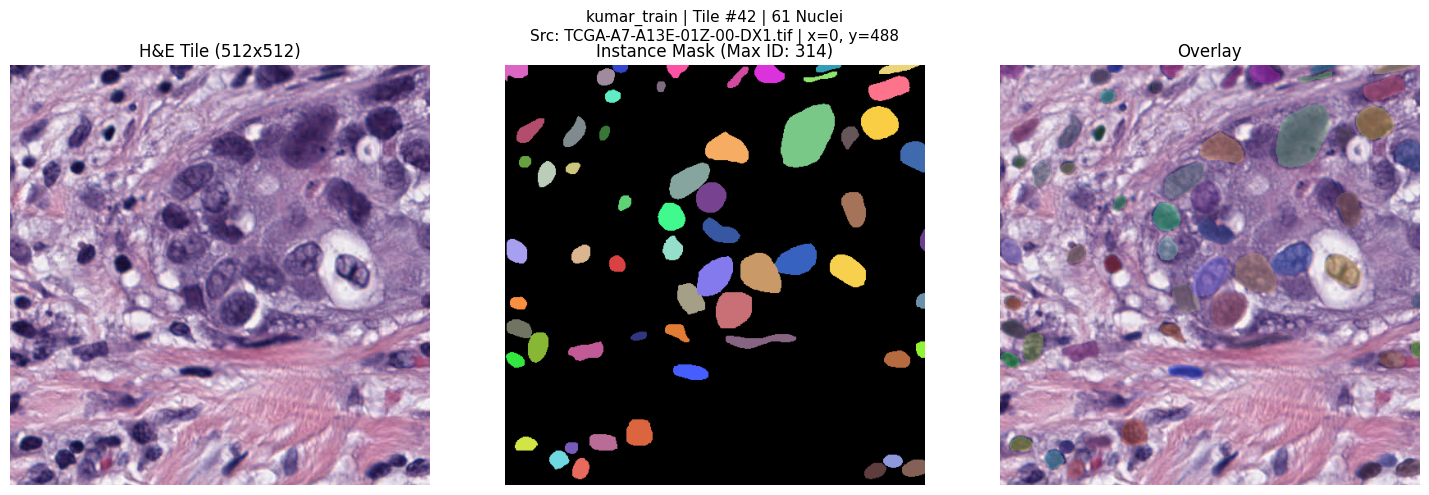

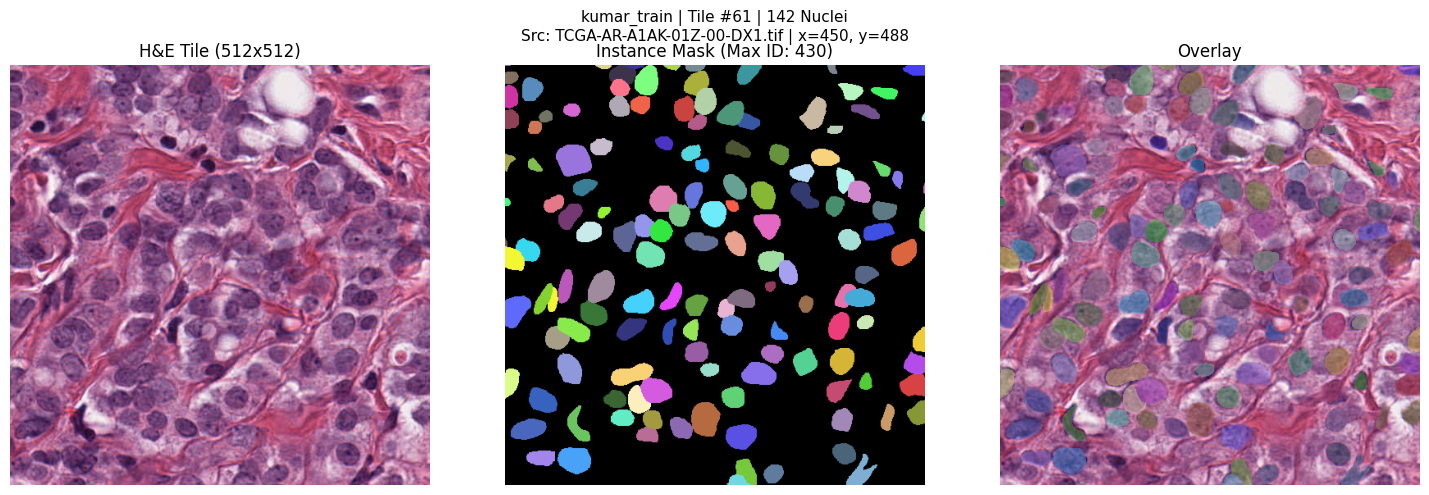

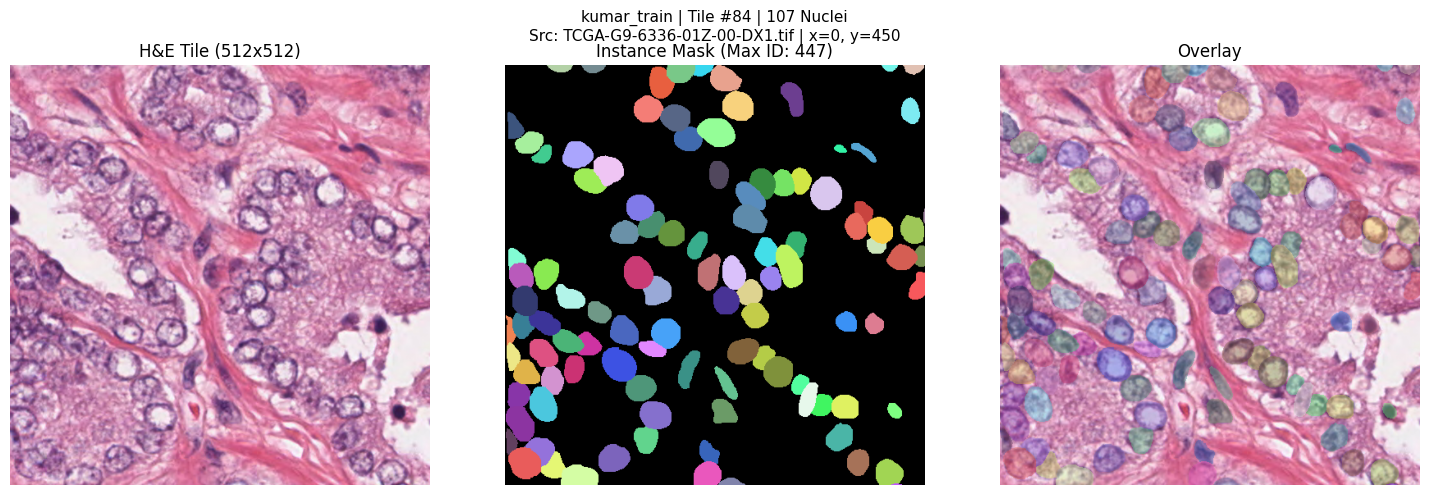


──────────────────────────────────────────────────────────────────────
📂 KUMAR_VAL | Total Tiles: 72
──────────────────────────────────────────────────────────────────────


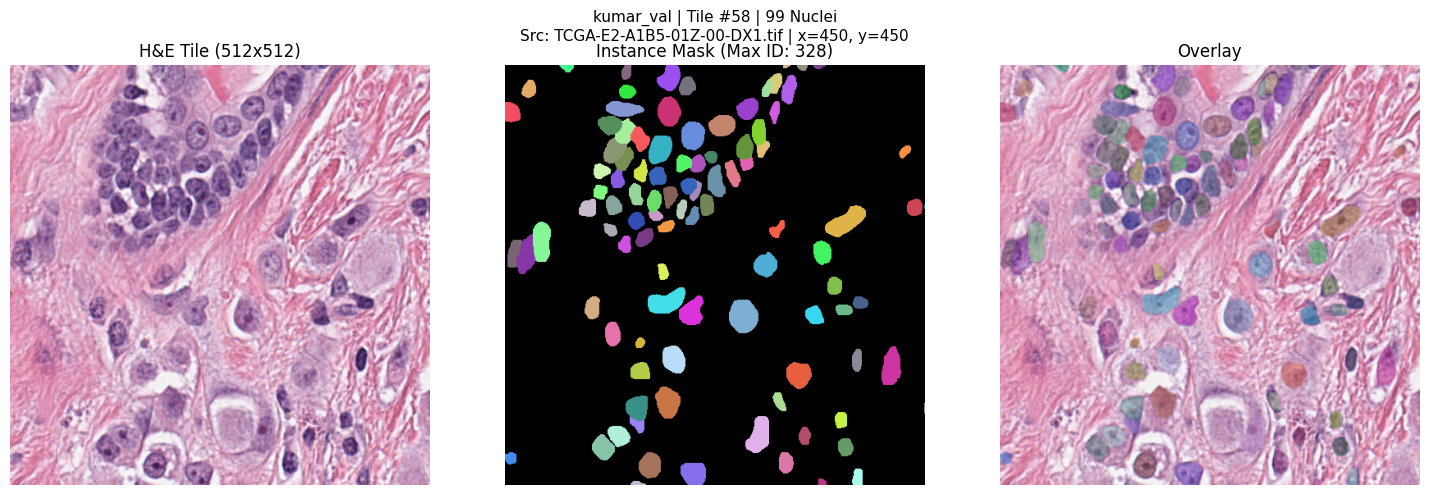

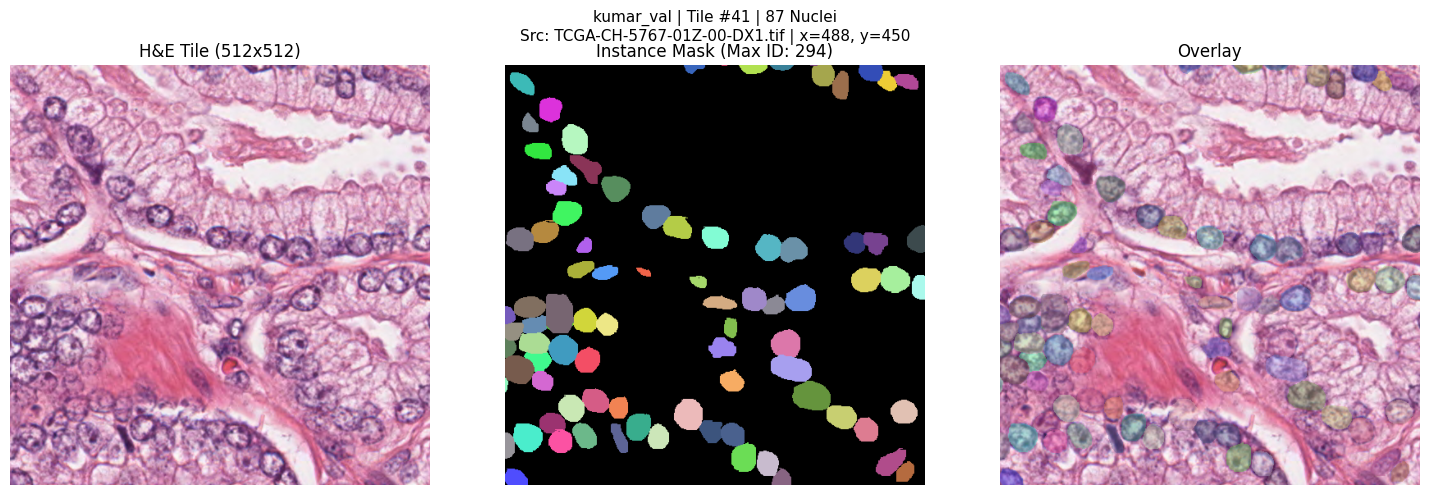

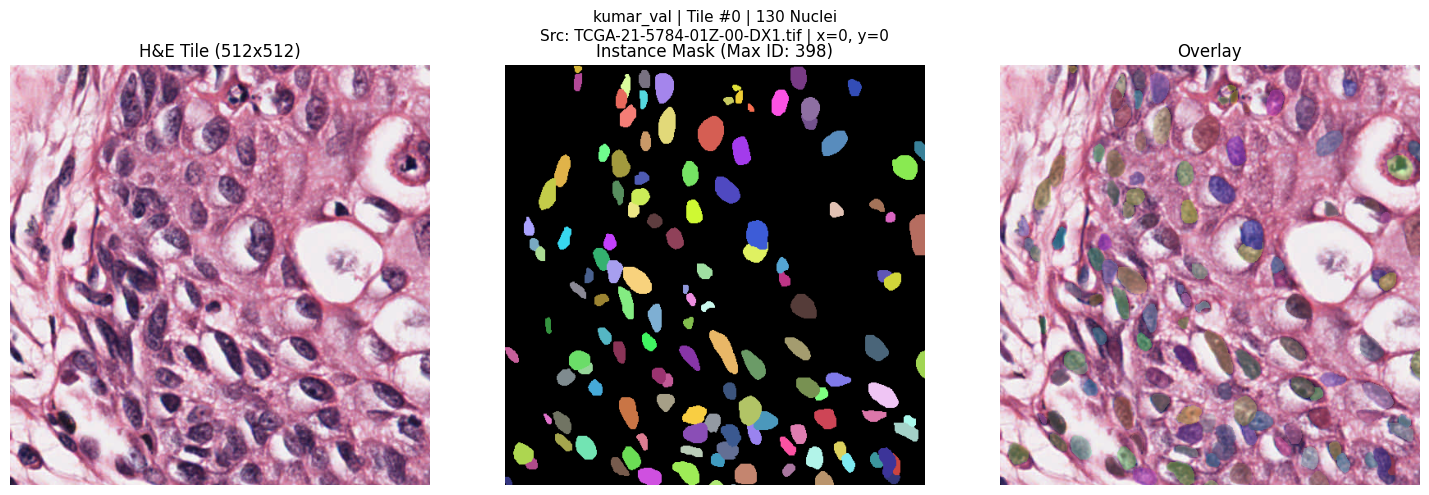


──────────────────────────────────────────────────────────────────────
📂 KUMAR_TEST | Total Tiles: 54
──────────────────────────────────────────────────────────────────────


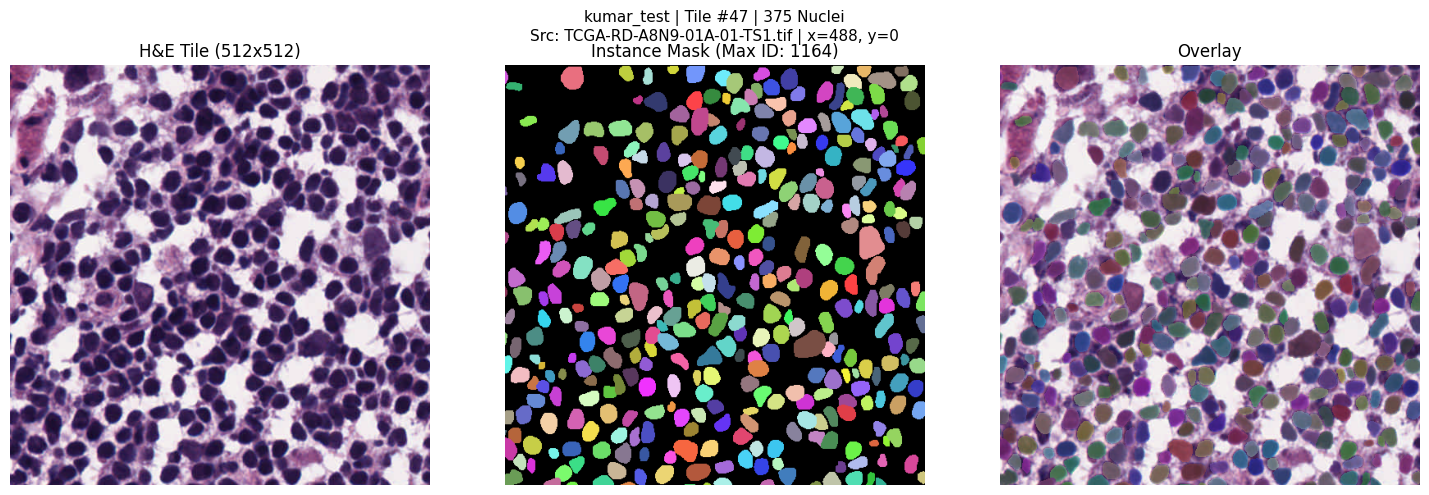

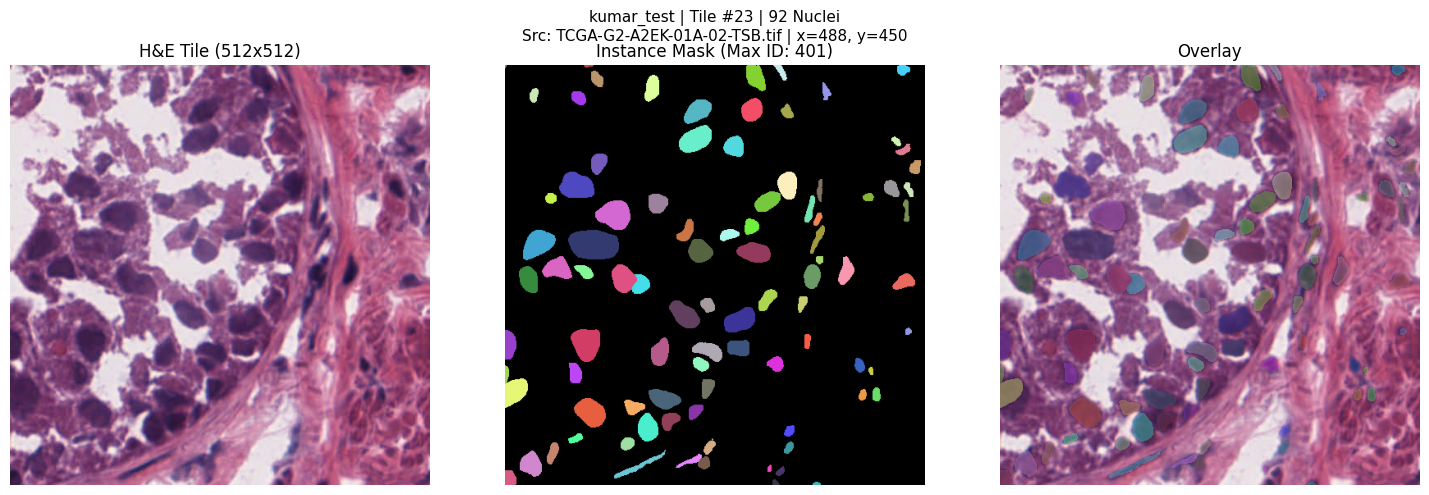

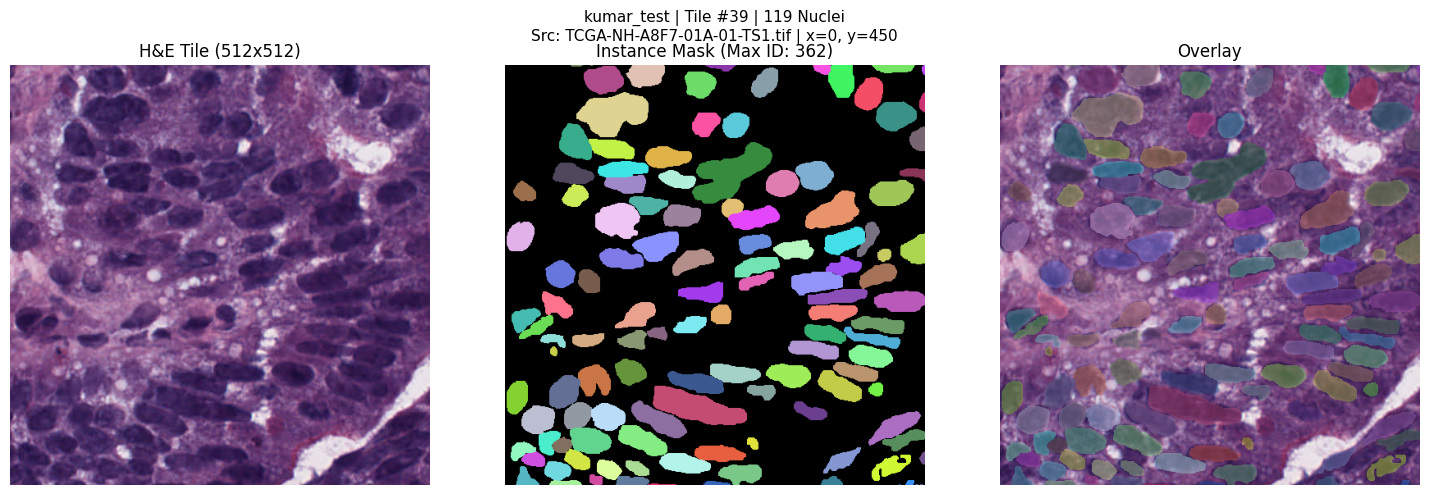

In [4]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from pathlib import Path
import pandas as pd

# --- CONFIGURATION ---
# Point this to the output directory defined in the previous step
ZARR_DATA_ROOT = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/kumar/zarr_data")

def colorize_instances(mask):
    """
    Creates a random RGB color map for an instance mask.
    Background (0) is always Black.
    """
    max_id = int(mask.max())
    if max_id == 0:
        return np.zeros((*mask.shape, 3), dtype=np.uint8)
    
    # Fixed seed for consistent colors per ID
    np.random.seed(42) 
    colors = np.random.randint(50, 255, size=(max_id + 1, 3), dtype=np.uint8)
    
    # Background black
    colors[0] = [0, 0, 0]
    
    return colors[mask]

def visualize_dataset(root_path, samples_per_split=3):
    """
    Visualize random tiles from the Kumar zarr dataset.
    """
    print("=" * 70)
    print(f"👀 INSPECTING KUMAR ZARR DATA AT: {root_path}")
    print("=" * 70)
    
    if not root_path.exists():
        print(f"❌ Path not found: {root_path}")
        return

    # Kumar splits defined in previous step
    splits = ['kumar_train', 'kumar_val', 'kumar_test']
    available_splits = [s for s in splits if (root_path / s).exists()]
    
    if not available_splits:
        print(f"⚠️  No split directories found in {root_path}")
        return

    for split_name in available_splits:
        split_path = root_path / split_name
        
        try:
            # Open zarr arrays
            z_img = zarr.open(str(split_path / "images.zarr"), mode='r')
            z_msk = zarr.open(str(split_path / "nuclei_masks.zarr"), mode='r')
            
            # Load metadata
            meta_path = split_path / "metadata.csv"
            metadata = pd.read_csv(meta_path) if meta_path.exists() else None
            
            num_images = z_img.shape[0]
            print(f"\n{'─' * 70}")
            print(f"📂 {split_name.upper()} | Total Tiles: {num_images}")
            print(f"{'─' * 70}")
            
            if num_images == 0:
                print("   (Empty split)")
                continue

            # Randomly select samples
            indices = random.sample(range(num_images), min(samples_per_split, num_images))
            
            for i, idx in enumerate(indices):
                img = z_img[idx]
                mask = z_msk[idx]
                
                # Instance stats
                unique_ids = np.unique(mask)
                num_nuclei = len(unique_ids) - 1 if 0 in unique_ids else len(unique_ids)
                
                # Metadata info
                meta_str = ""
                if metadata is not None:
                    row = metadata.iloc[idx]
                    meta_str = f"\nSrc: {row['original_file']} | x={row['patch_x']}, y={row['patch_y']}"

                # --- PLOTTING ---
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                fig.suptitle(f"{split_name} | Tile #{idx} | {num_nuclei} Nuclei{meta_str}", fontsize=11)
                
                # 1. Original Image
                ax[0].imshow(img)
                ax[0].set_title("H&E Tile (512x512)")
                ax[0].axis('off')
                
                # 2. Instance Mask
                colored_mask = colorize_instances(mask)
                ax[1].imshow(colored_mask)
                ax[1].set_title(f"Instance Mask (Max ID: {mask.max()})")
                ax[1].axis('off')
                
                # 3. Overlay
                # Create semi-transparent overlay
                overlay = img.copy().astype(float)
                alpha = np.where(mask > 0, 0.4, 0.0)[:,:,None] # 40% opacity for nuclei
                
                # Blend: Original * (1-alpha) + Mask * alpha
                blended = (overlay * (1 - alpha) + colored_mask * alpha).astype(np.uint8)
                
                ax[2].imshow(blended)
                ax[2].set_title("Overlay")
                ax[2].axis('off')
                
                plt.tight_layout()
                plt.show()

        except Exception as e:
            print(f"❌ Error visualizing {split_name}: {e}")

def verify_integrity(root_path):
    """
    Check dimensions, dtypes, and file existence.
    """
    print("\n" + "=" * 70)
    print("🔍 DATA INTEGRITY CHECK")
    print("=" * 70)
    
    splits = ['kumar_train', 'kumar_val', 'kumar_test']
    
    for s in splits:
        p = root_path / s
        if not p.exists(): continue
        
        try:
            z_img = zarr.open(str(p / "images.zarr"), mode='r')
            z_msk = zarr.open(str(p / "nuclei_masks.zarr"), mode='r')
            
            print(f"✅ {s}:")
            print(f"   Images: {z_img.shape} {z_img.dtype}")
            print(f"   Masks:  {z_msk.shape} {z_msk.dtype}")
            
            if z_img.shape[0] != z_msk.shape[0]:
                print(f"   🔴 CRITICAL: Count mismatch! Img: {z_img.shape[0]}, Mask: {z_msk.shape[0]}")
            
            if z_img.shape[1:] != (512, 512, 3):
                print(f"   🔴 CRITICAL: Incorrect image dimensions: {z_img.shape[1:]}")

            # Check for empty masks in a few random samples
            if z_msk.shape[0] > 0:
                sample_idx = random.randint(0, z_msk.shape[0]-1)
                if z_msk[sample_idx].max() == 0:
                    print(f"   ⚠️  Warning: Random sample #{sample_idx} has no nuclei (could be normal for background tiles)")
                else:
                    print(f"   Example #{sample_idx}: Max Nuclei ID = {z_msk[sample_idx].max()}")

        except Exception as e:
            print(f"   ❌ Error reading {s}: {e}")

if __name__ == "__main__":
    if ZARR_DATA_ROOT.exists():
        verify_integrity(ZARR_DATA_ROOT)
        visualize_dataset(ZARR_DATA_ROOT, samples_per_split=3)
    else:
        print(f"❌ Path not found: {ZARR_DATA_ROOT}")